<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Final Project - Introduction to Data Science
    <div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    @ FIT-HCMUS, VNU-HCM 📌
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 3.0 - Exploratory data analysis
</div>

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

## Exploring Data

In [2]:
cleaned_df = None
cleaned_df = pd.read_csv("./../data/processed.csv")

In [3]:
cleaned_df.head()

Name  Released year  \
0                   Fast X           2023   
1     Trolls Band Together           2023   
2         Robot Apocalypse           2021   
3  Five Nights at Freddy's           2023   
4              Oppenheimer           2023   

                                               Genre            Director  \
0                      'Action', 'Crime', 'Thriller'          Dan Mazeau   
1  'Animation', 'Family', 'Music', 'Fantasy', 'Co...          Thomas Dam   
2                        'Science Fiction', 'Action'  Marcus Friedlander   
3                                'Horror', 'Mystery'          Emma Tammi   
4                                 'Drama', 'History'   Christopher Nolan   

   Runtime (h)  Score    Status Language   Budget ($)  Revenue ($)  
0         2.37   72.0  Released  English  340000000.0  704709660.0  
1         1.53   72.0  Released  English   95000000.0  173800000.0  
2         1.45   21.0  Released  English          NaN          NaN  
3         1.83   78.0  Released  English   20000000.0  286700000.0  
4         3.02   81.0  Released  English  100000000.0  951000000.0

## Answering Questions

### Question 1: What is the interest in watching movies over the years?
**Purpose**: The above question aims to understand how people's engagement with movies has changed or remained constant over time. Film producers should rely on the observations in this question to grasp audience tastes. \
**How to answer this question**: 
- I will consider the `Genre` and `Released year` columns with performing *one-hot encoding* on `Genre` column and creating `one_hot_df`. I also filter the released movies. 
- Then, joining `Released year` in `one_hot_df` to create a new dataframe call `scent_df`. After that, group by `Released year` to find out distribution of scent for each year. Save to `distribution` dataframe.
- Visualize the result in a line plot with circle markers. I choose this chart because we have many years and 19 genres, so line plot with circle markers will display the distribution clearly.

In [4]:
released_movies = cleaned_df[cleaned_df['Status'] == 'Released']
one_hot_df = pd.DataFrame()

bin_edges = range(released_movies['Released year'].min(), released_movies['Released year'].max() + 11, 10)
released_movies['Year bin'] = pd.cut(released_movies['Released year'], bins=bin_edges, labels=False, include_lowest = True)

last_bin_label = released_movies['Year bin'].max()
released_movies.loc[released_movies['Year bin'] == last_bin_label, 'Year bin'] = last_bin_label - 1

bins = []
for i in range(0, 10):
    vals = released_movies.loc[released_movies['Year bin'] == i, 'Released year'].unique()
    bins.append(f'({vals.min()}, {vals.max()})')

released_movies = released_movies.drop(['Released year'], axis = 1)

def splitString(s):
    if s is np.nan:
        return None
    return s.split(', ')

fixed_df = released_movies['Genre'].apply(splitString)
stack = fixed_df.agg(pd.Series).stack()
dummy = pd.get_dummies(stack).groupby(level = 0).sum()
one_hot_df = pd.concat([one_hot_df, dummy], axis = 1)
one_hot_df = one_hot_df.fillna(0)

In [5]:
scent_df = one_hot_df.join(released_movies['Year bin'])

distribution = pd.DataFrame()
mask = scent_df.drop(columns = ['Year bin']).eq(1)
result = mask.groupby(scent_df['Year bin']).sum()
distribution = pd.concat([distribution, result], axis = 1)

# convert to frequency
for i, row in distribution.iterrows():
    sum_row = row.sum()
    for col in distribution.columns:
        distribution.at[i, col] = row[col] / sum_row

In [9]:
fig = px.area(distribution, markers = True)

fig.update_xaxes(tickvals = np.arange(0, 10), ticktext = bins)

fig.update_layout(
    xaxis_title = 'Released Year',
    yaxis_title = 'Frequency',
    title = 'Distribution of Movie Genres over the Years',
    legend_title = 'Genre',
    legend_traceorder="reversed"
)
fig.show()

# export html file to see the plot
fig.write_html("./figures/plot.html")

**Give observation:**
- According to the chart, we can see that over the years dramas account for a large number of movies. This is understandable, because most dramas have easy-to-understand and coherent plots, suitable for most audiences.
- Drama is followed by action, comedy and thriller. These types of movies bring laughter or thrill to the audience, making the movie watching experience better. Therefore, these genres have a certain foothold in the hearts of fans.
- Explains the high frequency from 1922 to 1932, the number of movies during this period was very small and mainly low budget films such as dramas, romance, family, etc. Therefore, genres mentioned above had a high count.
- Genres such as documentary, western, musical and war receive little attention. This can be explained by its dryness or high level of common sense, which was only popular during a certain period of time (usually before the 90s) and has gradually become obsolete in recent years.
- Some genres like romance, animation, horror are not much over the years but still have an average number of audiences.

### Question 2: What movie genres work well together?
**Purpose**: Helps production knows which movie genres can be easily combined, thereby increasing the company's profits based on popular genres that audiences often choose to watch. \
**To do it**, we will consider the `Name` and `Genre` columns. We create a matrix with row and column labels are `genres`. We then count the number of common occurrences of each pair of categories and save them in matrix. Finally, we visualize by drawing a heatmap with the lower half of the matrix.

In [7]:
# preprocessing
fixed_df = cleaned_df[['Name','Genre','Score','Revenue ($)']].reset_index(drop = True)
fixed_df['Genre'] = fixed_df['Genre'].str.split(', ')
fixed_df = fixed_df.explode('Genre').query('Genre == Genre')

temp = fixed_df[(fixed_df['Genre'] == "'Action'") | (fixed_df['Genre'] == "'Thriller'")].index
temp = temp.shape[0] - temp.nunique()

combination_df = pd.DataFrame(index = fixed_df['Genre'].unique(), columns = fixed_df['Genre'].unique())

# assign the count of combination
for i in range(len(fixed_df['Genre'].unique()) - 1):
    for j in range(i + 1, len(fixed_df['Genre'].unique())):
        temp = fixed_df[(fixed_df['Genre'] == fixed_df['Genre'].unique()[i]) | 
                        (fixed_df['Genre'] == fixed_df['Genre'].unique()[j])].index
        combination_df.at[fixed_df['Genre'].unique()[i], fixed_df['Genre'].unique()[j]] = temp.shape[0] - temp.nunique() if temp.shape[0] - temp.nunique() else 0
combination_df = combination_df.T.fillna(0)

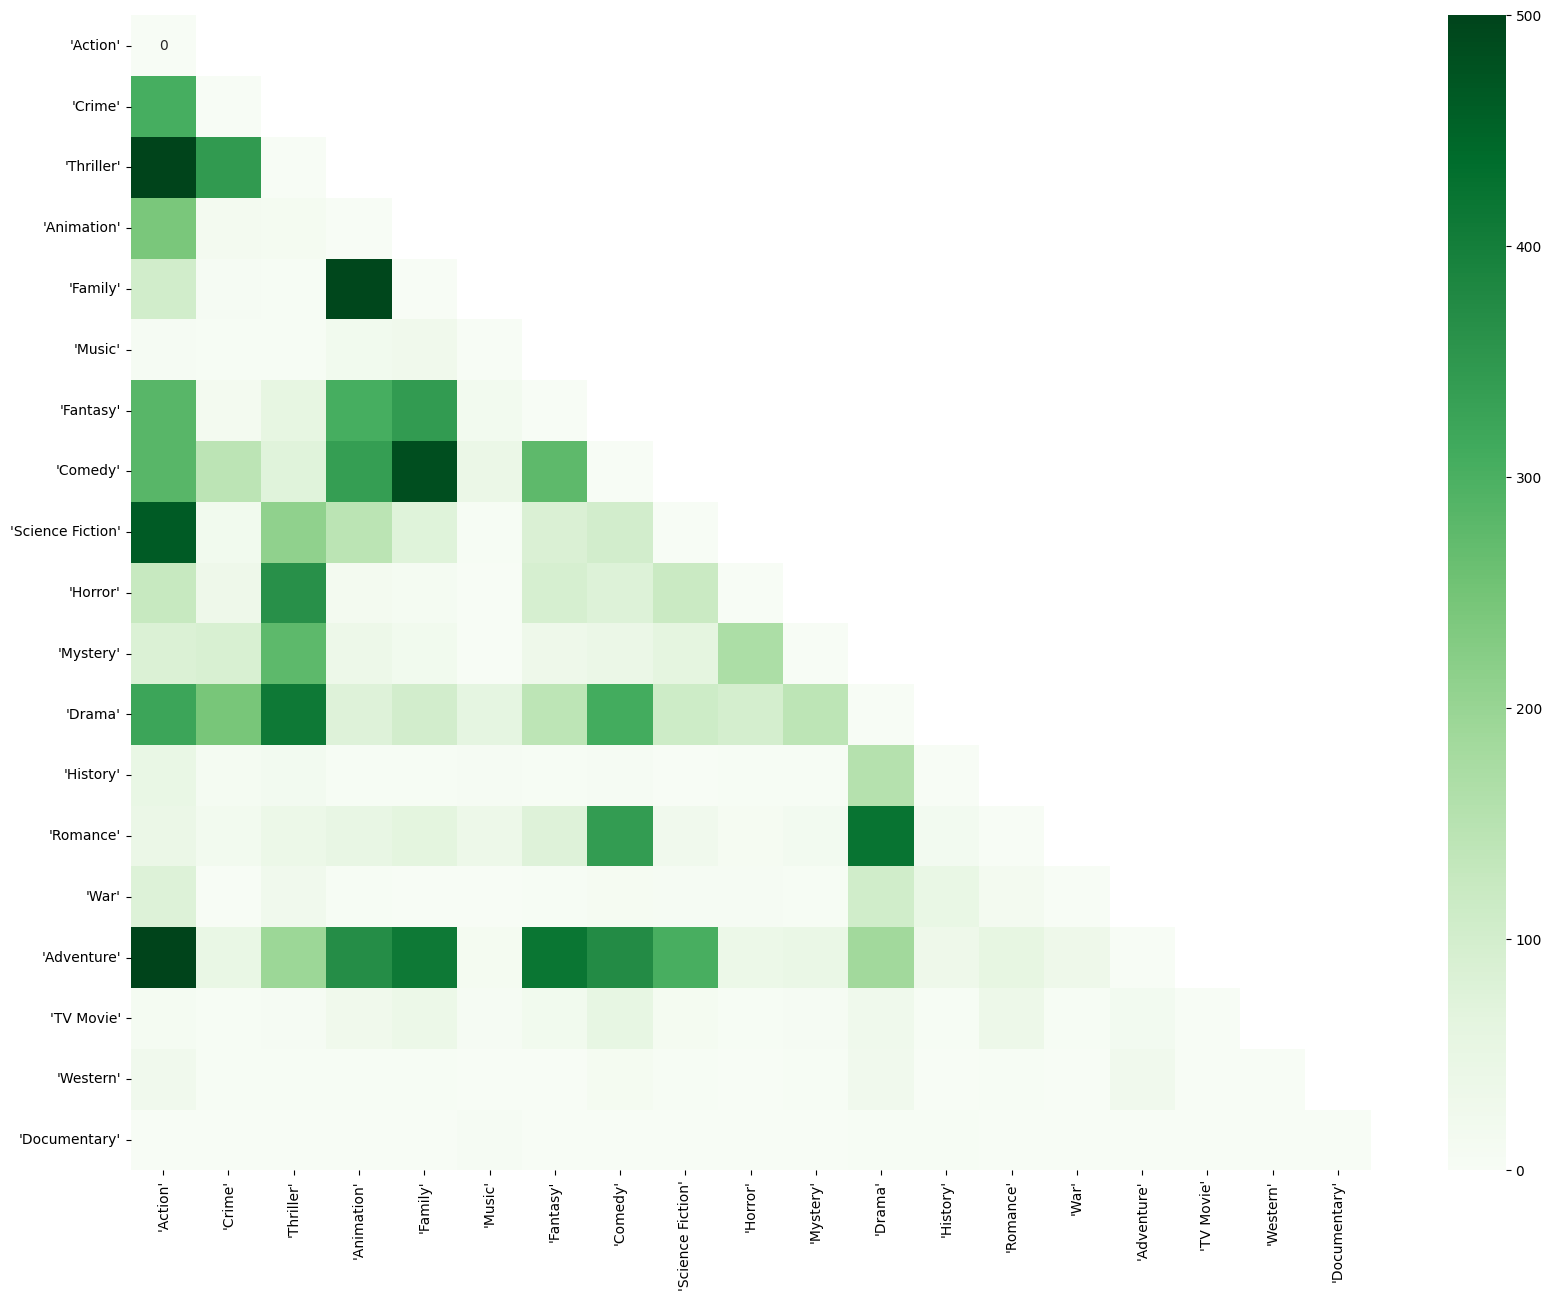

In [8]:
plt.figure(figsize = (20, 15))
mask = np.triu(np.ones_like(combination_df), k = 1)
sns.heatmap(combination_df, annot = True, fmt = 'd', cmap = 'Greens', mask = mask, vmin = 0, vmax = 500)
plt.show()

**Give Observation**:
- According to the heatmap, we can see some pair of genres have combined regularly:
    - `Action` and `Adventure`.
    - `Action` and `Thriller`.
    - `Family` and `Comedy`.
    - `Family` and `Animation`.
- That's understandable because their nature is the same. One side is a movie genre that brings dramatic suspense, the other side brings laughter or a feeling of relaxation.
- In conclusion, we recommend that filmmakers should make genre combination as below:
    - `Action`, `Adventure` and `Thriller`.
    - `Family`, `Comedy` and `Animation`.